In [1]:
from chunkation import Chunk
import numpy as np
import json, math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as scisignal
import pandas as pd

In [17]:
def filter_data(arr, n=10, wn=.03, method='bessel'):
    if method == 'bessel':
        b, a = scisignal.bessel(n, wn, 'low')
    elif method == 'butter':
        b, a = scisignal.butter(n, wn, 'low')
    else:
        print(f"ERROR: unknown method {method}")
        return None
    return scisignal.filtfilt(b, a, arr)

def avg_downsample(arr, skip):
    return [sum(arr[x:x+skip])/(len(arr[x:x+skip])) for x in range(0, len(arr), skip)]
    
    # only used here to process for normalization factors
def filter_signal(signal):
    return avg_downsample(filter_data(signal), 20)

# return the "min" and "max" for min-max scaling, using the YY-dip/hump normalization method
def normalization_factors(signal):
    skip = 3
    meds = [np.median(signal[i:min(len(signal), i+skip)]) for i in range(0,len(signal),skip)]
    chunk_size = int(len(meds)/6)
        # median of the mins of each tenth
    yy_offset = np.median([min(meds[i:min(i+chunk_size,len(meds))]) for i in range(0,len(meds),chunk_size)])
        # median of the maxes of each tenth
    top_offset = np.median([max(meds[i:min(i+chunk_size,len(meds))]) for i in range(0,len(meds),chunk_size)])
    return top_offset, yy_offset 

# returns true if signal is strictly U-shaped, i.e. the means of each step are monotonically decreasing  
# from beginning to the global min, then monotonically increasing from the global min to the end
def strict_dip(sigs):
    if len(sigs) <3:
        return True
    sig_means = [np.mean(sig) for sig in sigs]
    min_ind = sig_means.index(min(sig_means))
    decreasing = all(sig_means[i] > sig_means[i+1] for i in range(min_ind - 1))
    increasing = all(sig_means[i] < sig_means[i+1] for i in range(min_ind, len(sigs) - 1))
    return decreasing and increasing

def make_part_step_figure(sigs):
    start = 0
    plt.yticks([])
    plt.ylim([np.percentile(np.concatenate(sigs), 0), max(np.concatenate(sigs))])

    print(len(np.concatenate(sigs)))
    color = 'tab:grey' if strict_dip(sigs) else 'tab:orange'
    for sig in sigs:
        plt.plot([(i+start)/3012*1000 for i in range(len(sig))], sig, color = color, lw=.25)
        plt.hlines(np.mean(sig), [start/3012*1000], [(start+len(sig))/3012*1000], color='black')
        start += len(sig)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('tab:red')
        spine.set_linewidth(2)

def make_step_figure(mini_df, column):
    plt.figure(figsize=(20,4))
    plt.subplot(2,6,(1,6))
    raw = mini_df.raw.values[0]
    plt.plot([i/3012*1000 for i in range(len(raw))], raw, lw=.25)
    print(len(raw))
    plt.ylabel("Current (pA)")
    for dip in mini_df.dips:
        dip_sig = raw[dip[0]:dip[1]]
        ax = plt.gca()
        ax.add_patch(patches.Rectangle(
                (dip[0]/3012*1000, min(dip_sig)), 
                dip[1]/3012*1000-dip[0]/3012*1000, 
                max(dip_sig)-min(dip_sig), 
                facecolor="none", 
                ec='tab:red', 
                lw=2))

    for i, sigs in enumerate(mini_df[column]):
        plt.subplot(2,6,i+7)
        # sigs, _= chunk.plot(False)
        make_part_step_figure(sigs)

def plot(sigs):
    start = 0
    color = 'tab:green'
    cnt = 0
    for sig in sigs:
        if np.std(sig) < 2.2 or len(sig) > 30:
            plt.plot([i+start for i in range(len(sig))], sig, color = color)
            color = 'tab:red' if color == 'tab:green' else 'tab:green'
            start += len(sig)
            cnt += 1
            
    return cnt

def cnt_ttest_steps(row, pval):
    cnt = 0
    # plt.figure(figsize=(20,6))
    for i, dip in enumerate(row.dips):
        # plt.subplot(1,6,i+1)
        sigs, _ = ttest_chunk(row.raw[dip[0]:dip[1]], pval=pval)
        cnt += len(sigs)
        plot(sigs)
    return cnt

def ttest_chunk(sig, pval=0.00001):
    wn = 10
    splits = [0]
    last_split = wn * -2
    for i in range(wn, len(sig)-wn):
        if i < last_split + wn:
            continue
        if stats.ttest_ind(sig[i-wn:i], sig[i:i+wn]).pvalue <= pval:
            splits.append(i)
            last_split = i
    splits.append(len(sig))
    signals = [sig[s:e] for s, e in zip(splits[:-1], splits[1:])]
    return signals

In [3]:
pretty_df = pd.read_json('data/traces_df_sy.json')
df = pd.read_json('data/segments_df.json').groupby(by=['channel', 'run']).agg({'raw':sum,'aa':sum,'transformed':sum})
pretty_df['filtered'] = pretty_df.raw.apply(lambda raw: filter_data(raw, wn=.7))

pretty_df['dips'] = [[] for i in range(len(pretty_df))]
with open('data/pretty_df.json', 'r') as file:
    data = json.load(file)

for trace in data:
    file_upload = trace["file_upload"]

    run = file_upload[21:37]
    channel = float(file_upload[38:file_upload.find(".")])

    try:
        tdf = pretty_df[(pretty_df['run'] == run) & (pretty_df['channel'] == channel)]
        idx = tdf.index.values[0]
        if len(tdf) > 1:
            print(f"{len(tdf)} of {run}  {channel}")
    except:
        continue

    ses = [(yy_dip["value"]["start"], yy_dip["value"]["end"]) for yy_dip in trace["annotations"][0]["result"]]
    pretty_df.at[idx, 'dips'] = ses

def percent_dips(raw, dips):
    total = len(raw)
    if len(dips ) != 6:
        return np.nan
    yy = sum([e-s for s,e in dips])
    return yy/total

def trim(row):
    t = row.transformed
    i = np.where(np.array(t) >= 0)[0][0]
    start = max(i-1, 0)*20
    return row.raw[start:]


pretty_df['trimmed'] =  pretty_df.apply(lambda row: trim(row), axis=1) 
pretty_df['precent_dips'] = pretty_df.apply(lambda row: percent_dips(row.raw, row.dips), axis=1)
pretty_df['smoothed'] = pretty_df.raw.apply(filter_signal)
pretty_df['factors'] = pretty_df.smoothed.apply(normalization_factors)
pretty_df['scaled'] = pretty_df.apply(lambda row: (row.filtered - row.factors[1])/(row.factors[0]-row.factors[1]), axis=1)

/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_92177/4086805559.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = pd.read_json('data/segments_df.json').groupby(by=['channel', 'run']).agg({'raw':sum,'aa':sum,'transformed':sum})
/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_92177/4086805559.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = pd.read_json('data/segments_df.json').groupby(by=['channel', 'run']).agg({'raw':sum,'aa':sum,'transformed':sum})


## Calculate total number of amino acids attributed to YY dips

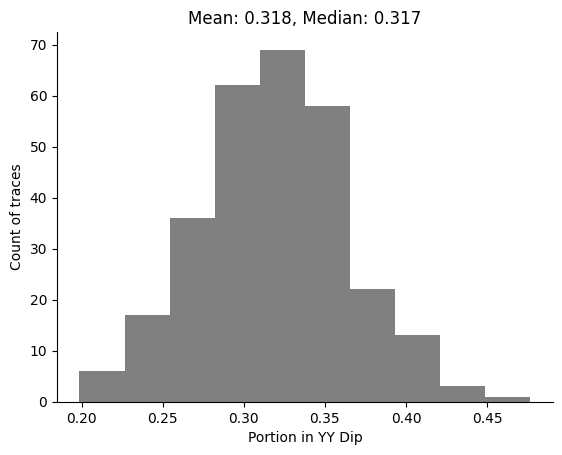

In [4]:
plt.hist(pretty_df['precent_dips'], color='grey')
plt.title(f"Mean: {round(np.nanmean(pretty_df['precent_dips']), 3)}, Median: {round(np.nanmedian(pretty_df['precent_dips']), 3)}")
plt.xlabel("Portion in YY Dip")
plt.ylabel("Count of traces")
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

NUM_AA = 359 * np.nanmedian(pretty_df['precent_dips'])
NUM_AA_PER_DIP = NUM_AA/6


In [5]:
df = pretty_df[pretty_df.pretty][pretty_df.dips.apply(len) != 0].reset_index(drop=True)
df = df.explode('dips').reset_index(drop=True)

/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_92177/2766287226.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = pretty_df[pretty_df.pretty][pretty_df.dips.apply(len) != 0].reset_index(drop=True)


## Estimate ClpX stepping using Bayesian-based segmentation algorithm

18


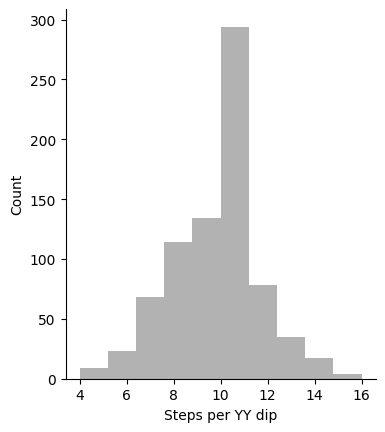

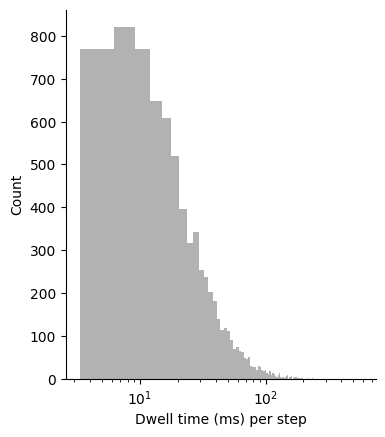

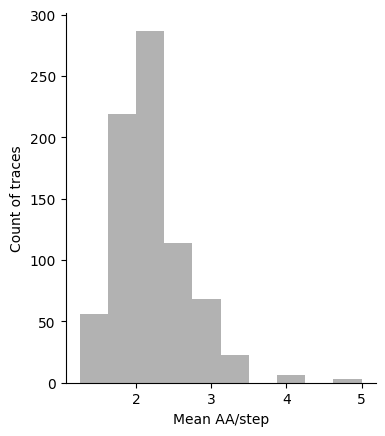

In [6]:
# bayesian-based segmentation approach: takes ~3.5-4 min
threshold = 18
MIN_LEN = 10

print(threshold)
df["obj"] = df.apply(lambda row: Chunk(row.filtered[row.dips[0]:row.dips[1]], threshold, MIN_LEN), axis=1)
df['chunked'] = df["obj"].apply(lambda c: c.plot(False)[0])
df['X_chunked'] = df['chunked'].apply(len)

plt.figure(figsize=(4, 4.8))
plt.hist(df[df.chunked.apply(strict_dip)].chunked.apply(len).values, alpha = .6, color='tab:grey')
plt.ylabel('Count')
plt.xlabel('Steps per YY dip')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

plt.figure(figsize=(4, 4.8))
plt.hist(np.concatenate(df[df.chunked.apply(strict_dip)].chunked.apply(lambda d: [len(d) for d in d]).values)/3.012, label='no backstep', alpha = .6,bins=200, color='tab:grey')
plt.xscale('log')
plt.ylabel('Count')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('Dwell time (ms) per step')
plt.show()

plt.figure(figsize=(4., 4.8))
plt.hist(20/df[df.chunked.apply(strict_dip)].chunked.apply(len).values, alpha = .6, color='tab:grey')
plt.ylabel('Count of traces')
plt.xlabel('Mean AA/step')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_92177/3859929265.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = df[df.run == run][df.channel == chan]
/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_92177/3859929265.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = df[df.run == run][df.channel == chan]


20221122_run02_a 341.0 6
19025
676
932
816
1072
909
606


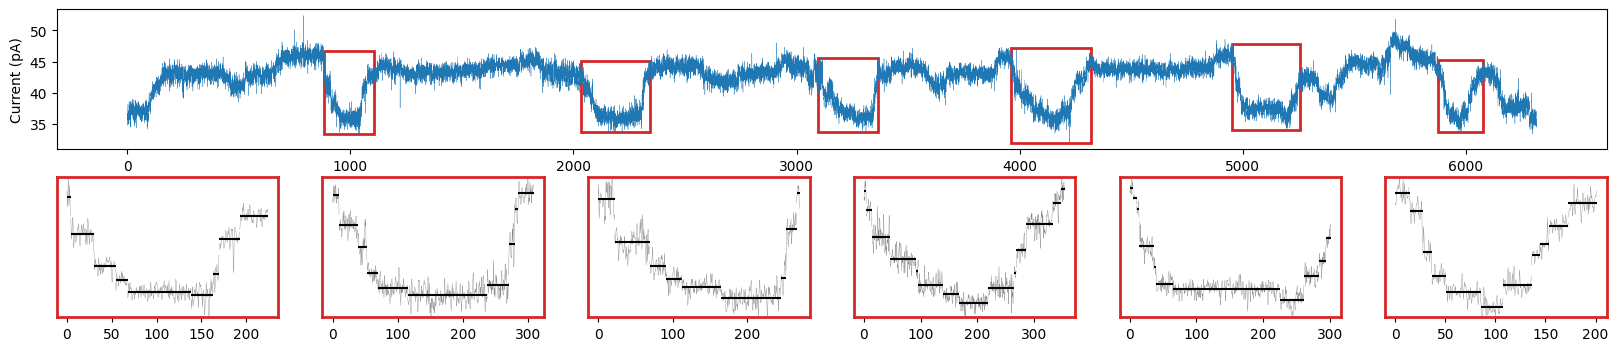

676


/var/folders/rb/4nfyc06110b944pkssbl1yrw0000gn/T/ipykernel_92177/3859929265.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sigs = df[df.run == '20221122_run02_a'][df.channel == 341].chunked.values[0]


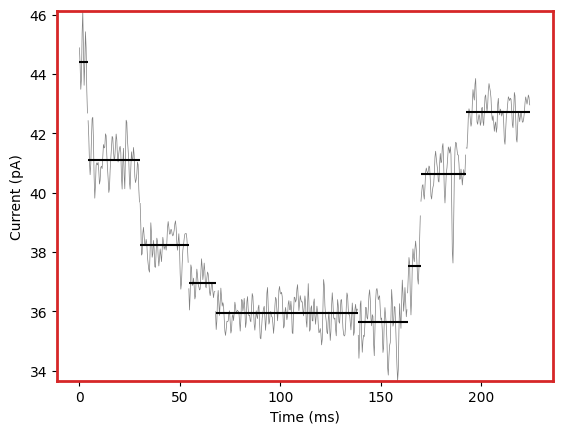

In [7]:
## plot example for channel 341

for run in df.run.unique():
    for chan in df[df.run == run].channel.unique():
        if chan != 341:
            continue
        tdf = df[df.run == run][df.channel == chan]
        if len(tdf[tdf.chunked.apply(strict_dip)]) == 6:
            print(run,chan,len(tdf))
            make_step_figure(tdf, 'chunked')
            plt.show()

def make_part_step_figure(sigs):
    start = 0
    # plt.yticks([])
    plt.ylim([np.percentile(np.concatenate(sigs), 0), max(np.concatenate(sigs))])

    print(len(np.concatenate(sigs)))
    color = 'tab:grey' if strict_dip(sigs) else 'tab:orange'
    for sig in sigs:
        plt.plot([(i+start)/3012*1000 for i in range(len(sig))], sig, color = color, lw=.5)
        plt.hlines(np.mean(sig), [start/3012*1000], [(start+len(sig))/3012*1000], color='black', label='Step')
        start += len(sig)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('tab:red')
        spine.set_linewidth(2)
        
sigs = df[df.run == '20221122_run02_a'][df.channel == 341].chunked.values[0]
make_part_step_figure(sigs)
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none',
"font.family":"Arial"
}
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.show()

## Calculate number of amino acids per step
### with stddev using error carry forward

In [32]:
print(stats.ttest_ind(
    np.concatenate(df[df.chunked.apply(strict_dip)].chunked.apply(lambda d: [len(d) for d in d]).values)/3.012,
    np.concatenate(df[~df.chunked.apply(strict_dip)].chunked.apply(lambda d: [len(d) for d in d]).values)/3.012
))


n_aa_per_dip = 359/6* np.nanmean(pretty_df['precent_dips'])
n_steps_per_dip = df[df.chunked.apply(strict_dip)].chunked.apply(len).values

a = np.std(n_steps_per_dip)/np.mean(n_steps_per_dip)
c = np.nanstd(n_aa_per_dip)/np.nanmean(n_aa_per_dip)

std = math.sqrt(a**2 + c **2)
print(f"aa/step: {round(np.nanmean(n_aa_per_dip)/np.mean(n_steps_per_dip), 1)}\nstd aa/stp: {round(std, 1)}\naa/dip {round(n_aa_per_dip, 1)}")

Ttest_indResult(statistic=2.4743817198749807, pvalue=0.013354896660717683)
aa/step: 2.0
std aa/stp: 0.2
aa/dip 19.0


## Estimate ClpX stepping using t-test segmentation algorithm

In [23]:
# time: 2 to 5 min
log_p_val = -4.3 # 10^-4.3 = 0.000050
print(10**(log_p_val))

df["ttest"] = df.apply(lambda row: ttest_chunk(row.filtered[row.dips[0]:row.dips[1]], pval = 10**(log_p_val)), axis=1)

5.011872336272725e-05


In [31]:
print(stats.ttest_ind(
    np.concatenate(df[df.ttest.apply(strict_dip)].ttest.apply(lambda d: [len(d) for d in d]).values)/3.012,
    np.concatenate(df[~df.ttest.apply(strict_dip)].ttest.apply(lambda d: [len(d) for d in d]).values)/3.012
))


n_aa_per_dip = 359/6* np.nanmean(pretty_df['precent_dips'])
n_steps_per_dip = df[df.ttest.apply(strict_dip)].ttest.apply(len).values

a = np.std(n_steps_per_dip)/np.mean(n_steps_per_dip)
c = np.nanstd(n_aa_per_dip)/np.nanmean(n_aa_per_dip)

std = math.sqrt(a**2 + c **2)
print(f"aa/step: {round(np.nanmean(n_aa_per_dip)/np.mean(n_steps_per_dip), 1)}\nstd aa/stp: {round(std, 1)}\naa/dip {round(n_aa_per_dip, 1)}")


Ttest_indResult(statistic=8.504116607972945, pvalue=1.9070891186922566e-17)
aa/step: 1.9
std aa/stp: 0.2
aa/dip 19.0


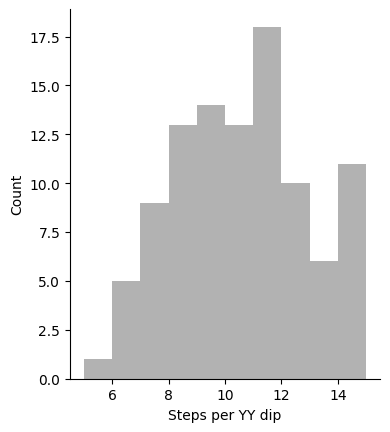

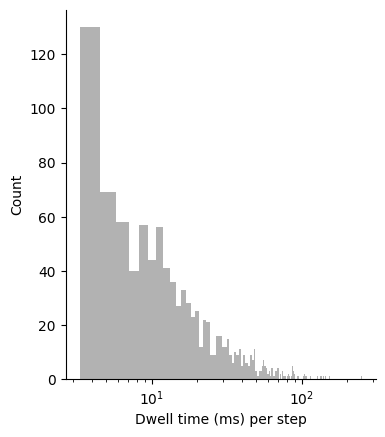

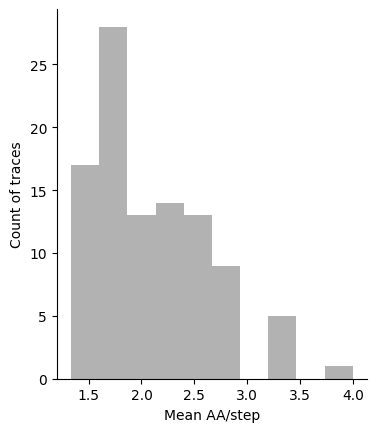

In [35]:
plt.figure(figsize=(4, 4.8))
plt.hist(df[df['ttest'].apply(strict_dip)]['ttest'].apply(len).values, 
        label='no backstep', 
        alpha = .6, 
        color='tab:grey')
plt.ylabel('Count')
plt.xlabel('Steps per YY dip')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

plt.figure(figsize=(4, 4.8))
plt.hist(np.concatenate(df[df['ttest'].apply(strict_dip)]['ttest'].apply(lambda d: [len(d) for d in d]).values)/3.012, 
        label='no backstep', 
        alpha = .6,
        bins=200, 
        color='tab:grey')
plt.xscale('log')
plt.ylabel('Count')
plt.xlabel('Dwell time (ms) per step')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

plt.figure(figsize=(4., 4.8))
plt.hist(20/df[df['ttest'].apply(strict_dip)]['ttest'].apply(len).values, alpha = .6, color='tab:grey')
plt.ylabel('Count of traces')
plt.xlabel('Mean AA/step')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()